In [1]:
try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
print(tf.__version__)

1.15.0


In [3]:
# Function used to make this notebook's output stable across runs.
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Method to plot the Perceptron's decision boundary.
def plot_decision_boundary(classifier, X, y, title):    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    XX_ = np.c_[xx.ravel(), yy.ravel()]
        
    Z = classifier.predict(XX_)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(5, 5))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('$x_1$',fontsize=20)
    plt.ylabel('$x_2$',fontsize=20)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)    

    plt.show()
    
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot
    
class MyMLP():
    
    def __init__(self, filename):
        self.filename = filename

    def predict(self, X_):
        with tf.Session() as sess:
            saver.restore(sess, self.filename)
            res = sess.run(softmax, feed_dict={X : X_})
            Z = np.zeros((X_.shape[0]),)
            inc = 0
            for element in res:
                Z[inc] = np.argmax(element)
                inc += 1
        return Z

def createLogDir(root_logdir="./ex7_logs"):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)
    return logdir

In [4]:
from sklearn.datasets import make_circles 
seed = 21
random.seed(seed)
N = 1000
X_, y_ = make_circles(n_samples=N, random_state=42, noise=0.1, factor=0.2)

In [5]:
logdir = createLogDir()

print('LOG dir: ',logdir)

LOG dir:  ./ex7_logs/run-20201128175545/


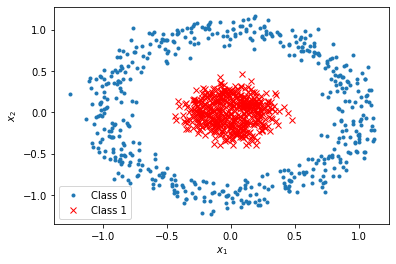

In [6]:
idx0 = np.argwhere(y_ == 0)
idx1 = np.argwhere(y_ == 1)


plt.plot(X_[idx0,0], X_[idx0,1], '.', label='Class 0')
plt.plot(X_[idx1,0], X_[idx1,1], 'rx', label='Class 1')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

# GradientDescentOptimizer

In [7]:
reset_graph()

num_epoch = 30000
learning_rate = 0.1

X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

W_ = tf.Variable(tf.random_uniform([2, 4], -2.0, 5.0), name="W_")
W_1 = tf.Variable(tf.random_uniform([4, 2], -2.0, 5.0), name="W_1")

B_ = tf.Variable(tf.random_uniform(shape=[4], minval=-2.0, maxval=5.0), name='B_')
B_1= tf.Variable(tf.random_uniform(shape=[2], minval=-2.0, maxval=5.0), name='B_1')


# Hidden layer and output layer.
with tf.name_scope('hidden'):
    logits = tf.matmul(tf.sigmoid(tf.matmul(X, W_) + B_) , W_1)+ B_1
    softmax = tf.nn.softmax(logits)

# Error estimation
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

saver = tf.train.Saver()

loss_summary = tf.summary.scalar('loss', loss)

acc_summary = tf.summary.scalar('accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())



In [8]:
sess = tf.Session()
sess.run(init)

loss_vec_gd = []
epoch_vec_gd = []
for i in range(0, num_epoch):
    error = sess.run(training_op, feed_dict={X: X_, y: y_})
    if(i % 100) == 0:
        loss_value = sess.run(loss, feed_dict={X: X_, y: y_})
        acc = sess.run(accuracy, feed_dict={X: X_, y: y_})
        print('Epoch: ' + str(i) + ' - Error: ' + str( loss_value ) + ' - Acc: ' + str(acc))
        loss_vec_gd.append(loss_value)
        epoch_vec_gd.append(i)
        save_path = saver.save(sess, logdir+'three_classes_model_gd_opt.ckpt')
    loss_str = sess.run(loss_summary, feed_dict={X: X_, y: y_})  
    file_writer.add_summary(loss_str, i)
    acc_str = sess.run(acc_summary, feed_dict={X: X_, y: y_})
    file_writer.add_summary(acc_str, i)
    
for el in sess.run(softmax, feed_dict={X: X_}):
    print('    ',el)
    
save_path = saver.save(sess, logdir+'three_classes_gd_optimizer_final.ckpt')
    
sess.close()
 
print ("Training Complete")

Epoch: 0 - Error: 1.1055943 - Acc: 0.5
Epoch: 100 - Error: 0.6324161 - Acc: 0.771
Epoch: 200 - Error: 0.6051455 - Acc: 0.789
Epoch: 300 - Error: 0.58443564 - Acc: 0.796
Epoch: 400 - Error: 0.56606627 - Acc: 0.804
Epoch: 500 - Error: 0.548783 - Acc: 0.814
Epoch: 600 - Error: 0.53217095 - Acc: 0.825
Epoch: 700 - Error: 0.51611197 - Acc: 0.836
Epoch: 800 - Error: 0.50063396 - Acc: 0.843
Epoch: 900 - Error: 0.48582458 - Acc: 0.851
Epoch: 1000 - Error: 0.47177684 - Acc: 0.855
Epoch: 1100 - Error: 0.4585598 - Acc: 0.863
Epoch: 1200 - Error: 0.4462083 - Acc: 0.865
Epoch: 1300 - Error: 0.4347232 - Acc: 0.868
Epoch: 1400 - Error: 0.42408067 - Acc: 0.869
Epoch: 1500 - Error: 0.4142421 - Acc: 0.875
Epoch: 1600 - Error: 0.40516493 - Acc: 0.879
Epoch: 1700 - Error: 0.39680713 - Acc: 0.883
Epoch: 1800 - Error: 0.389127 - Acc: 0.886
Epoch: 1900 - Error: 0.38207895 - Acc: 0.891
Epoch: 2000 - Error: 0.3756081 - Acc: 0.89
Epoch: 2100 - Error: 0.3696477 - Acc: 0.885
Epoch: 2200 - Error: 0.36411878 - Acc:

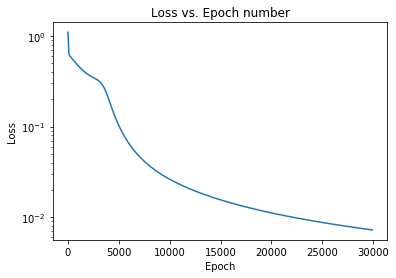

In [9]:
plt.plot(epoch_vec_gd, loss_vec_gd)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

In [10]:
# Calculate and return the accuracy on the test data
with tf.Session() as sess:
    saver.restore(sess, logdir+"three_classes_gd_optimizer_final.ckpt")
    acc = sess.run(accuracy, feed_dict={X: X_, y: y_})

print('Gradient Descent Optimizer accuracy: %1.4f' % (acc))

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128175545/three_classes_gd_optimizer_final.ckpt
Gradient Descent Optimizer accuracy: 1.0000


INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128175545/three_classes_gd_optimizer_final.ckpt


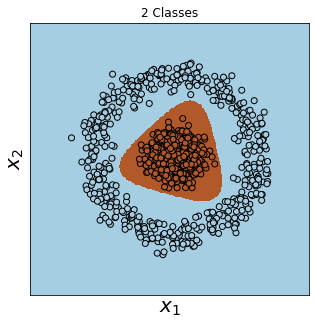

In [11]:
filenameGD = logdir+"three_classes_gd_optimizer_final.ckpt"

clf = MyMLP(filenameGD)

plot_decision_boundary(clf, X_, y_, '2 Classes')

# AdamOptimizer

In [12]:
reset_graph()

num_epoch = 30000
learning_rate = 0.1

X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

W_ = tf.Variable(tf.random_uniform([2, 4], -2.0, 5.0), name="W_")
W_1 = tf.Variable(tf.random_uniform([4, 2], -2.0, 5.0), name="W_1")

B_ = tf.Variable(tf.random_uniform(shape=[4], minval=-2.0, maxval=5.0), name='B_')
B_1= tf.Variable(tf.random_uniform(shape=[2], minval=-2.0, maxval=5.0), name='B_1')


# Hidden layer and output layer.
with tf.name_scope('hidden'):
    logits = tf.matmul(tf.sigmoid(tf.matmul(X, W_) + B_) , W_1)+ B_1
    softmax = tf.nn.softmax(logits)

# Error estimation
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

saver = tf.train.Saver()

loss_summary = tf.summary.scalar('loss', loss)

acc_summary = tf.summary.scalar('accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())


In [13]:
sess = tf.Session()
sess.run(init)

loss_vec_adam = []
epoch_vec_adam = []
for i in range(0, num_epoch):
    error = sess.run(training_op, feed_dict={X: X_, y: y_})
    if(i % 100) == 0:
        loss_value = sess.run(loss, feed_dict={X: X_, y: y_})
        acc = sess.run(accuracy, feed_dict={X: X_, y: y_})
        print('Epoch: ' + str(i) + ' - Error: ' + str( loss_value ) + ' - Acc: ' + str(acc))
        loss_vec_adam.append(loss_value)
        epoch_vec_adam.append(i)
        save_path = saver.save(sess, logdir+'three_classes_adam_optimizer_final.ckpt')
    loss_str = sess.run(loss_summary, feed_dict={X: X_, y: y_})  
    file_writer.add_summary(loss_str, i)
    acc_str = sess.run(acc_summary, feed_dict={X: X_, y: y_})
    file_writer.add_summary(acc_str, i)

for el in sess.run(softmax, feed_dict={X: X_}):
    print('    ',el)
    
save_path = saver.save(sess, logdir+'three_classes_adam_optimizer_final.ckpt')
    
sess.close()
 
print ("Training Complete")

Epoch: 0 - Error: 0.8982214 - Acc: 0.5
Epoch: 100 - Error: 0.11175529 - Acc: 0.999
Epoch: 200 - Error: 0.0401699 - Acc: 0.999
Epoch: 300 - Error: 0.022919632 - Acc: 0.999
Epoch: 400 - Error: 0.015689027 - Acc: 0.999
Epoch: 500 - Error: 0.011706197 - Acc: 0.999
Epoch: 600 - Error: 0.008922241 - Acc: 1.0
Epoch: 700 - Error: 0.0068102307 - Acc: 1.0
Epoch: 800 - Error: 0.005484498 - Acc: 1.0
Epoch: 900 - Error: 0.00460289 - Acc: 1.0
Epoch: 1000 - Error: 0.0039555337 - Acc: 1.0
Epoch: 1100 - Error: 0.0034506565 - Acc: 1.0
Epoch: 1200 - Error: 0.00304351 - Acc: 1.0
Epoch: 1300 - Error: 0.0027094546 - Acc: 1.0
Epoch: 1400 - Error: 0.0024324663 - Acc: 1.0
Epoch: 1500 - Error: 0.0022003308 - Acc: 1.0
Epoch: 1600 - Error: 0.0020032898 - Acc: 1.0
Epoch: 1700 - Error: 0.0018338361 - Acc: 1.0
Epoch: 1800 - Error: 0.0016864389 - Acc: 1.0
Epoch: 1900 - Error: 0.001557039 - Acc: 1.0
Epoch: 2000 - Error: 0.001442564 - Acc: 1.0
Epoch: 2100 - Error: 0.0013406241 - Acc: 1.0
Epoch: 2200 - Error: 0.00124931

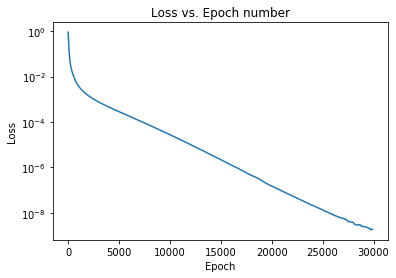

In [14]:
plt.plot(epoch_vec_adam, loss_vec_adam)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs. Epoch number')
plt.show()

INFO:tensorflow:Restoring parameters from ./ex7_logs/run-20201128175545/three_classes_adam_optimizer_final.ckpt


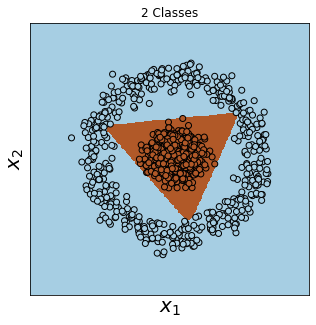

In [15]:
filenameGD = logdir+"three_classes_adam_optimizer_final.ckpt"

clf = MyMLP(filenameGD)

plot_decision_boundary(clf, X_, y_, '2 Classes')

# O AdamOptimizer mostrou-se superior comparado ao GradientDescentOptimizer pelo fato de necessitar de menos épocas para atingir um menor erro